In [1]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.ar_model import AutoReg


warnings.simplefilter(action="ignore", category=FutureWarning)

# Data Wrangling

In [2]:
#wrangle function

def wrangle(filepath, resample = '1H'):
    df = pd.read_csv(filepath, delim_whitespace=True)

    # Drop columns with QD as they are separators
    df = df.loc[:, ~df.columns.str.endswith('QD')]
    
    # Replace placeholder values with NaN
    df.replace(['//', '__', '---'], pd.NA, inplace=True)

    #convert time col into datetime type
    df["Time"] = pd.to_datetime(df["Time"])

    # Set the Time column as the index
    df.set_index("Time", inplace=True)

    #Convert the rest of columns to float type
    for column in df.columns:
        if column != "Time":
            df[column] = pd.to_numeric(df[column], errors='coerce')
    
    
    # Drop columns that have zero non-null values
    df.dropna(axis=1, how='all', inplace=True)

    #Drop columns with null values more than half of column
    for i in df.columns:
        if df[i].isnull().sum()>0.5* len(df[i]):
            df.drop(columns = i, inplace =True)
            
    # Convert the timezone to Europe/Athens
    df.index = df.index.tz_convert('Europe/Athens')

    y = df['foF2'].resample(resample).mean().ffill()
    y=y['2023-01-27':]



    return y

    

In [3]:
y = wrangle('DIDBGetValues_edited.txt')
y.head()

Time
2023-01-27 00:00:00+02:00    4.341250
2023-01-27 01:00:00+02:00    4.108182
2023-01-27 02:00:00+02:00    3.775417
2023-01-27 03:00:00+02:00    3.950556
2023-01-27 04:00:00+02:00    4.069545
Freq: H, Name: foF2, dtype: float64

In [4]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 795 entries, 2023-01-27 00:00:00+02:00 to 2023-03-01 02:00:00+02:00
Freq: H
Series name: foF2
Non-Null Count  Dtype  
--------------  -----  
795 non-null    float64
dtypes: float64(1)
memory usage: 12.4 KB


# Explore

In [5]:
px.box(data_frame= y)

Looks like there are no outliers!, maximum foF2 is at 12.785 Hz, minimum is at 2.96

In [6]:
fig = px.line(y, x=y.index, y='foF2', title='Critical Frequency over Time')

fig.update_layout(
    xaxis_title='Date Time',
    yaxis_title='foF2 [MHz]',  # Or any unit you want, such as 'foF2 [Hz]'
    xaxis_title_font=dict(size=14, family='Arial', color='blue'),
    yaxis_title_font=dict(size=14, family='Arial', color='blue')
)

# Show the plot
fig.show()

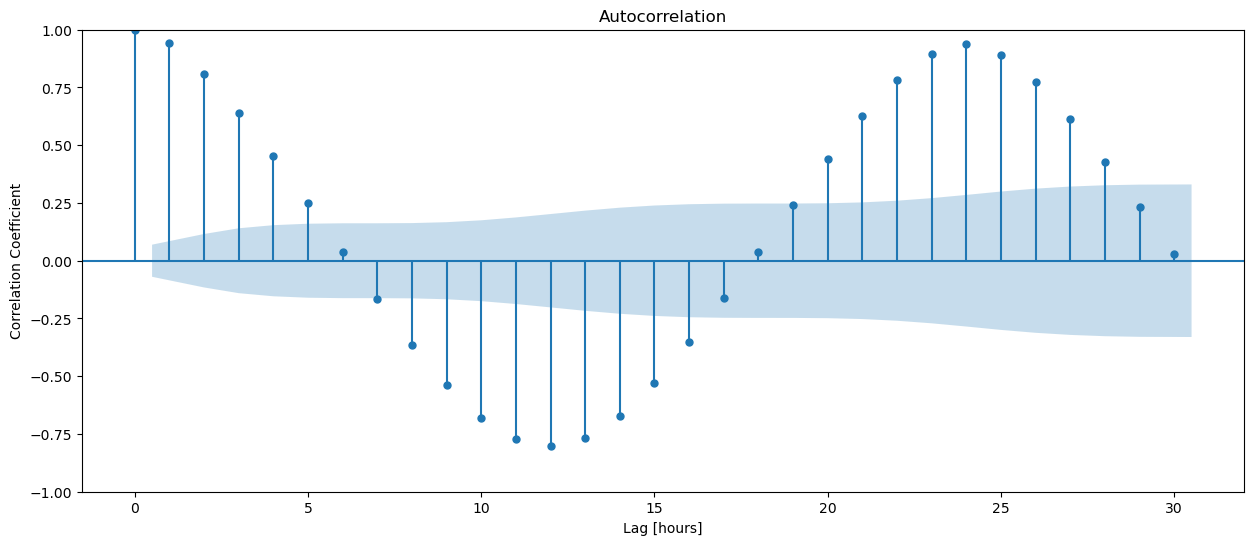

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

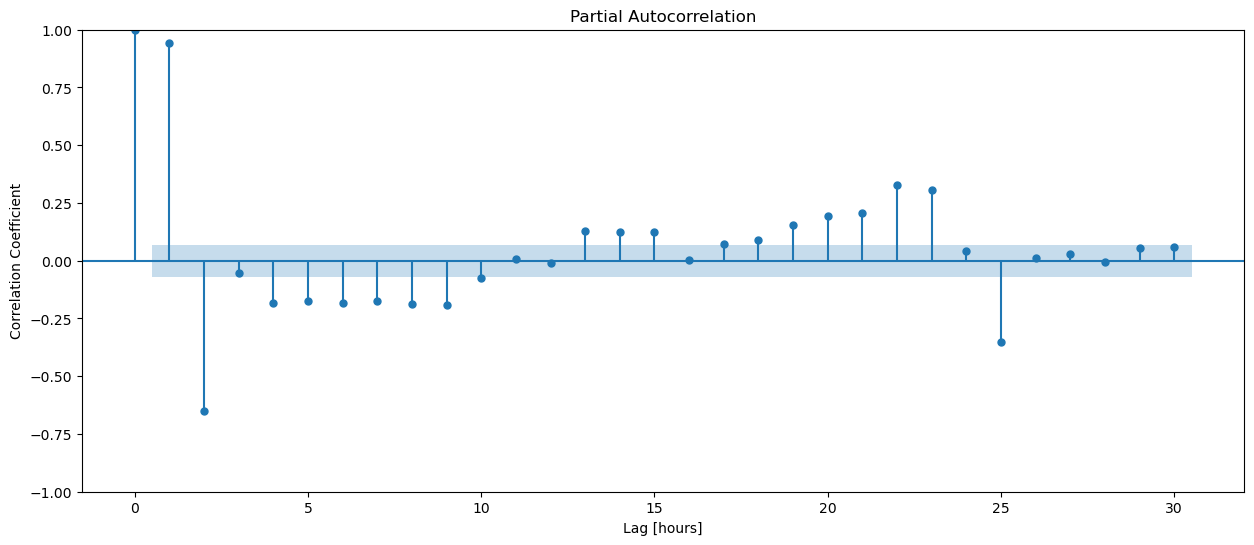

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

# Split

In [9]:
cutoff_test = int(len(y)*0.95)

y_train = y[:cutoff_test]
y_test = y[cutoff_test:]

# Build Model

## Baseline

In [10]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean foF2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2));

Mean foF2 Reading: 7.07
Baseline MAE: 2.78


## AutoRegressive Model

In [11]:
model = AutoReg(y_train, lags=25).fit()
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[25:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 0.3541792136346909


In [12]:
y_train_resid = model.resid
y_train_resid.tail()

Time
2023-02-27 06:00:00+02:00   -0.202941
2023-02-27 07:00:00+02:00    1.262158
2023-02-27 08:00:00+02:00    0.301449
2023-02-27 09:00:00+02:00    1.225840
2023-02-27 10:00:00+02:00   -0.779791
Freq: H, dtype: float64

<Axes: xlabel='Time'>

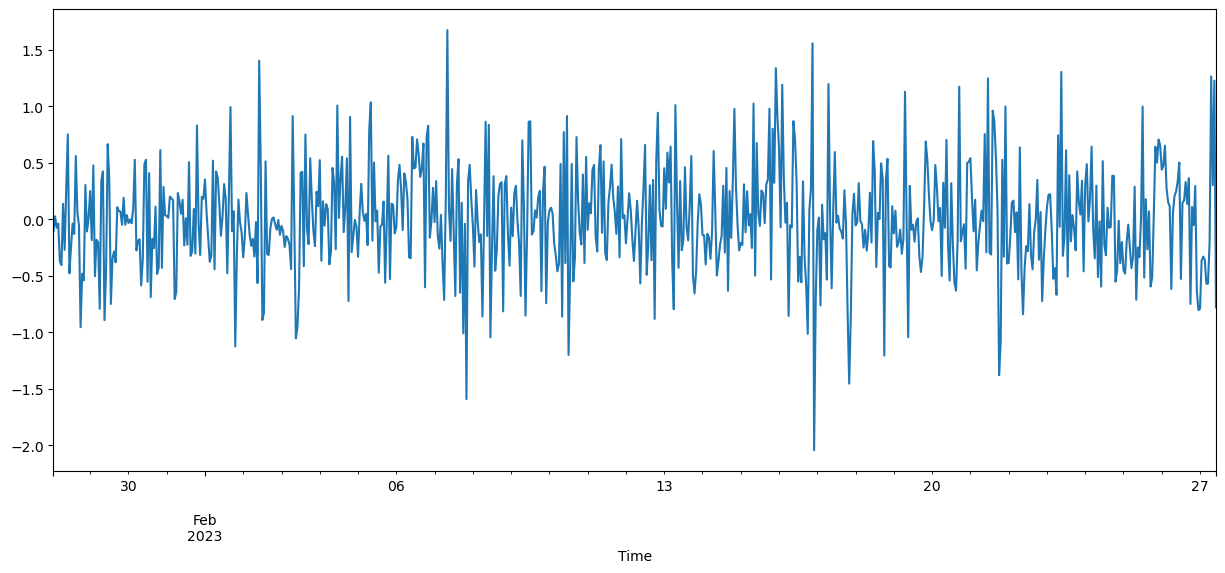

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot()

<Axes: >

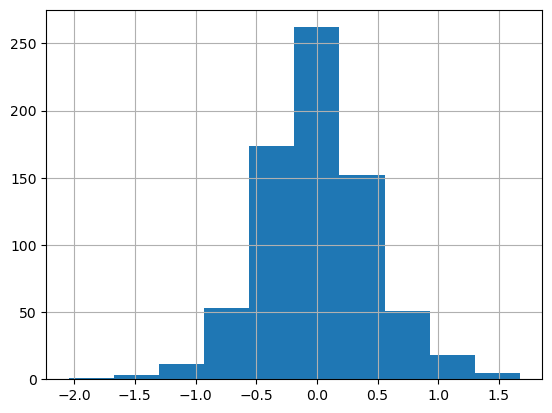

In [14]:
y_train_resid.hist()

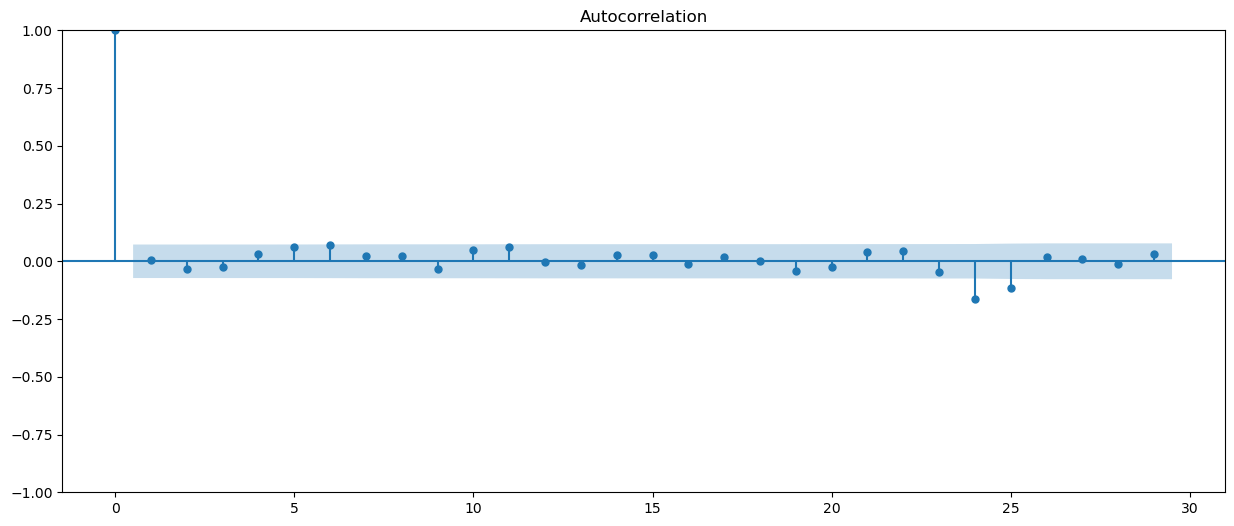

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

## Evaluate

In [16]:
y_test.index.min()

Timestamp('2023-02-27 11:00:00+0200', tz='Europe/Athens')

In [17]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 0.6840444156206379


In [18]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [19]:
fig = px.line(df_pred_test, labels={"value": "foF2"})
fig.show()

In [20]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

# Assuming y_train and y_test are pandas Series with a DateTime index
y_pred_wfv = []
history = y_train.copy()

for i in range(len(y_test)):
    # Fit the AutoReg model on the current history
    model = AutoReg(history, lags=26).fit()
    
    # Forecast the next value
    next_pred = model.forecast(steps=1)
    
    # Append the forecasted value to the predictions list
    y_pred_wfv.append(next_pred[0])
    
    # Update the history with the actual value from y_test
    # next_pred.index is used to align with y_test index
    history = pd.concat([history, y_test[next_pred.index]])

# Convert the list of predictions to a Series
y_pred_wfv = pd.Series(y_pred_wfv, index=y_test.index)

print(y_pred_wfv)


Time
2023-02-27 11:00:00+02:00    10.952652
2023-02-27 12:00:00+02:00    11.820619
2023-02-27 13:00:00+02:00    12.360697
2023-02-27 14:00:00+02:00    12.039106
2023-02-27 15:00:00+02:00    11.886233
2023-02-27 16:00:00+02:00    10.898940
2023-02-27 17:00:00+02:00    10.943360
2023-02-27 18:00:00+02:00     8.333082
2023-02-27 19:00:00+02:00     8.513171
2023-02-27 20:00:00+02:00     5.317032
2023-02-27 21:00:00+02:00     4.881035
2023-02-27 22:00:00+02:00     4.468125
2023-02-27 23:00:00+02:00     4.221509
2023-02-28 00:00:00+02:00     4.501946
2023-02-28 01:00:00+02:00     3.899830
2023-02-28 02:00:00+02:00     3.914462
2023-02-28 03:00:00+02:00     3.775284
2023-02-28 04:00:00+02:00     3.631366
2023-02-28 05:00:00+02:00     4.109956
2023-02-28 06:00:00+02:00     4.561921
2023-02-28 07:00:00+02:00     7.086962
2023-02-28 08:00:00+02:00    11.101897
2023-02-28 09:00:00+02:00    12.444918
2023-02-28 10:00:00+02:00    10.818337
2023-02-28 11:00:00+02:00    11.665991
2023-02-28 12:00:00+

In [21]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.46


# Results

In [22]:
print(model.params)

const       0.263257
foF2.L1     0.908901
foF2.L2    -0.309325
foF2.L3     0.084628
foF2.L4    -0.008439
foF2.L5     0.046621
foF2.L6    -0.032417
foF2.L7    -0.013538
foF2.L8     0.048410
foF2.L9    -0.053571
foF2.L10   -0.012545
foF2.L11    0.080177
foF2.L12   -0.093567
foF2.L13    0.005629
foF2.L14   -0.027956
foF2.L15    0.092127
foF2.L16   -0.070896
foF2.L17    0.057256
foF2.L18   -0.040926
foF2.L19   -0.019399
foF2.L20    0.039775
foF2.L21    0.006003
foF2.L22    0.011656
foF2.L23    0.117414
foF2.L24    0.478540
foF2.L25   -0.317541
foF2.L26   -0.011695
dtype: float64


In [23]:
df_pred_test= pd.DataFrame({'y_test': y_test, 'y_pred_wfv':y_pred_wfv}, index= y_test.index)
fig = px.line(df_pred_test, labels={"value": "foF2"})
fig.show()